In [1]:
#import import_analysis code
from import_analysis import *

import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors

#%matplotlib notebook 
%matplotlib inline
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.dpi'] = 100

#stroke-miterlimit change this for svg file output
%reload_ext autoreload

"""
This code takes two paired read FASTQ aligned files (output from Bowtie) and shuttles through the file to build a
score matrix of basecalls, given a certain read cutoff
"""

'\nThis code takes two paired read FASTQ aligned files (output from Bowtie) and shuttles through the file to build a\nscore matrix of basecalls, given a certain read cutoff\n'

In [2]:
#make a list of the # of files and corresponding names
#e.g. input file 1_R1.fastq.map has corresponding sample name of "A10-F1-aga (new)"
filelist=['1', '2', '3','4','5','6','7','8']

names = (
'88',
'YHM6', #strain with highest mutation diversity
'90',
'91',
'YHM2.PT7KO',#negative control with disrupted T7 promoter 
'93',
'94',
'95')

        
#initialize blank lists in which to store the NGS analysis output
Mlist, Mnormlist = [], []

In [ ]:
#for each file in filelist
#loop through and compute 'M' using the function SeqScoreMAKER
#'M' represents the sequencing data parsed down to a single array of 5x(length seq) where
#    we have the # of occurances of [A,T,C,G,N] x (len seq)
#    'M' is useful for computing the frequency of a base at each position


for i in filelist:
    
    #delineate filenames, directory structure should be noted
    file1 = './paired/' + i + "_1.fastq.map"
    file2 = './paired/' + i + "_2.fastq.map"
    file3 = './paired/' + i + "_1b.fastq"
    
    #working on file
    print(file3)
    
    #computes above described 'M' matrix w/ # of occurances of [A,T,C,G,N] x (len seq)
    #filters by cutoff (Q scores removed)
    M = SeqScoreMAKER(file1, file2, file3, cutoff=5, seqlength=3000, verbose=False)
    
  
    #normalize sequence information from counts to frequencies
    norm=np.sum(M,axis=1,dtype=float)
    norm[norm==0]=1.0
    Mnorm=(1.0/norm)*M.T
    
    #dump array to save it as a file named ip_M_#
    np.array([M,Mnorm]).dump('ip_M'+i)
    
    #append the M and Mnorm arrays to the list for storing
    Mlist.append([M, i])
    Mnormlist.append([Mnorm,i])
    
    print('finished: '+i)

In [3]:
###RELOAD ALL FILES STORED IN BACKUP AS ip_M format
filelist=filelist
#initialize lists of M and Mnorm
Mlist, Mnormlist = [], []
M=[]
M.append(np.load("ip_M1.npy",allow_pickle=True))
M.append(np.load("ip_M2.npy",allow_pickle=True))
M.append(np.load("ip_M3.npy",allow_pickle=True))
M.append(np.load("ip_M4.npy",allow_pickle=True))
M.append(np.load("ip_M5.npy",allow_pickle=True))    
M.append(np.load("ip_M6.npy",allow_pickle=True))
M.append(np.load("ip_M7.npy",allow_pickle=True))
M.append(np.load("ip_M8.npy",allow_pickle=True))


#function load_files, pulls the filelist numpy dumps back
#M=load_files(filelist, pathA='ip_M', pathB='.npy')
Mlist, Mnormlist = np.array(M)[:,0], np.array(M)[:,1]

#removes the 5th row of all N's
for i in range(len(Mnormlist)):
    Mnormlist[i] = M_norm(Mnormlist[i][:4].T)

(1500.0, 3000.0)

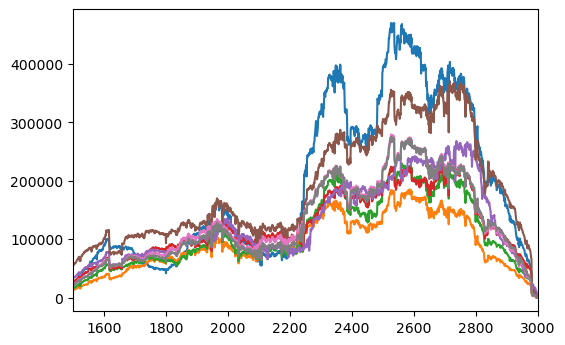

In [4]:
#plot sequencing depth reached for each sample
#good way to check if the depth is sufficient for reasonable mutation detection (e.g. rates of 1E-4 require >1E5 depth)

def plot_counts(Marray, labels):
    #for plotting the total read count arrays, sanity checks
    
    try:
        i=0
        for array in Marray:
            #print(np.shape(array))
            plt.plot(range(len(array)), np.sum(array, axis=1), label=str(labels[i]))
            i+=1
    except:
        plt.plot(range(len(Marray)), np.sum(Marray, axis=1))

plot_counts(Mlist[:], labels=names)
plt.xlim([1500,3000])

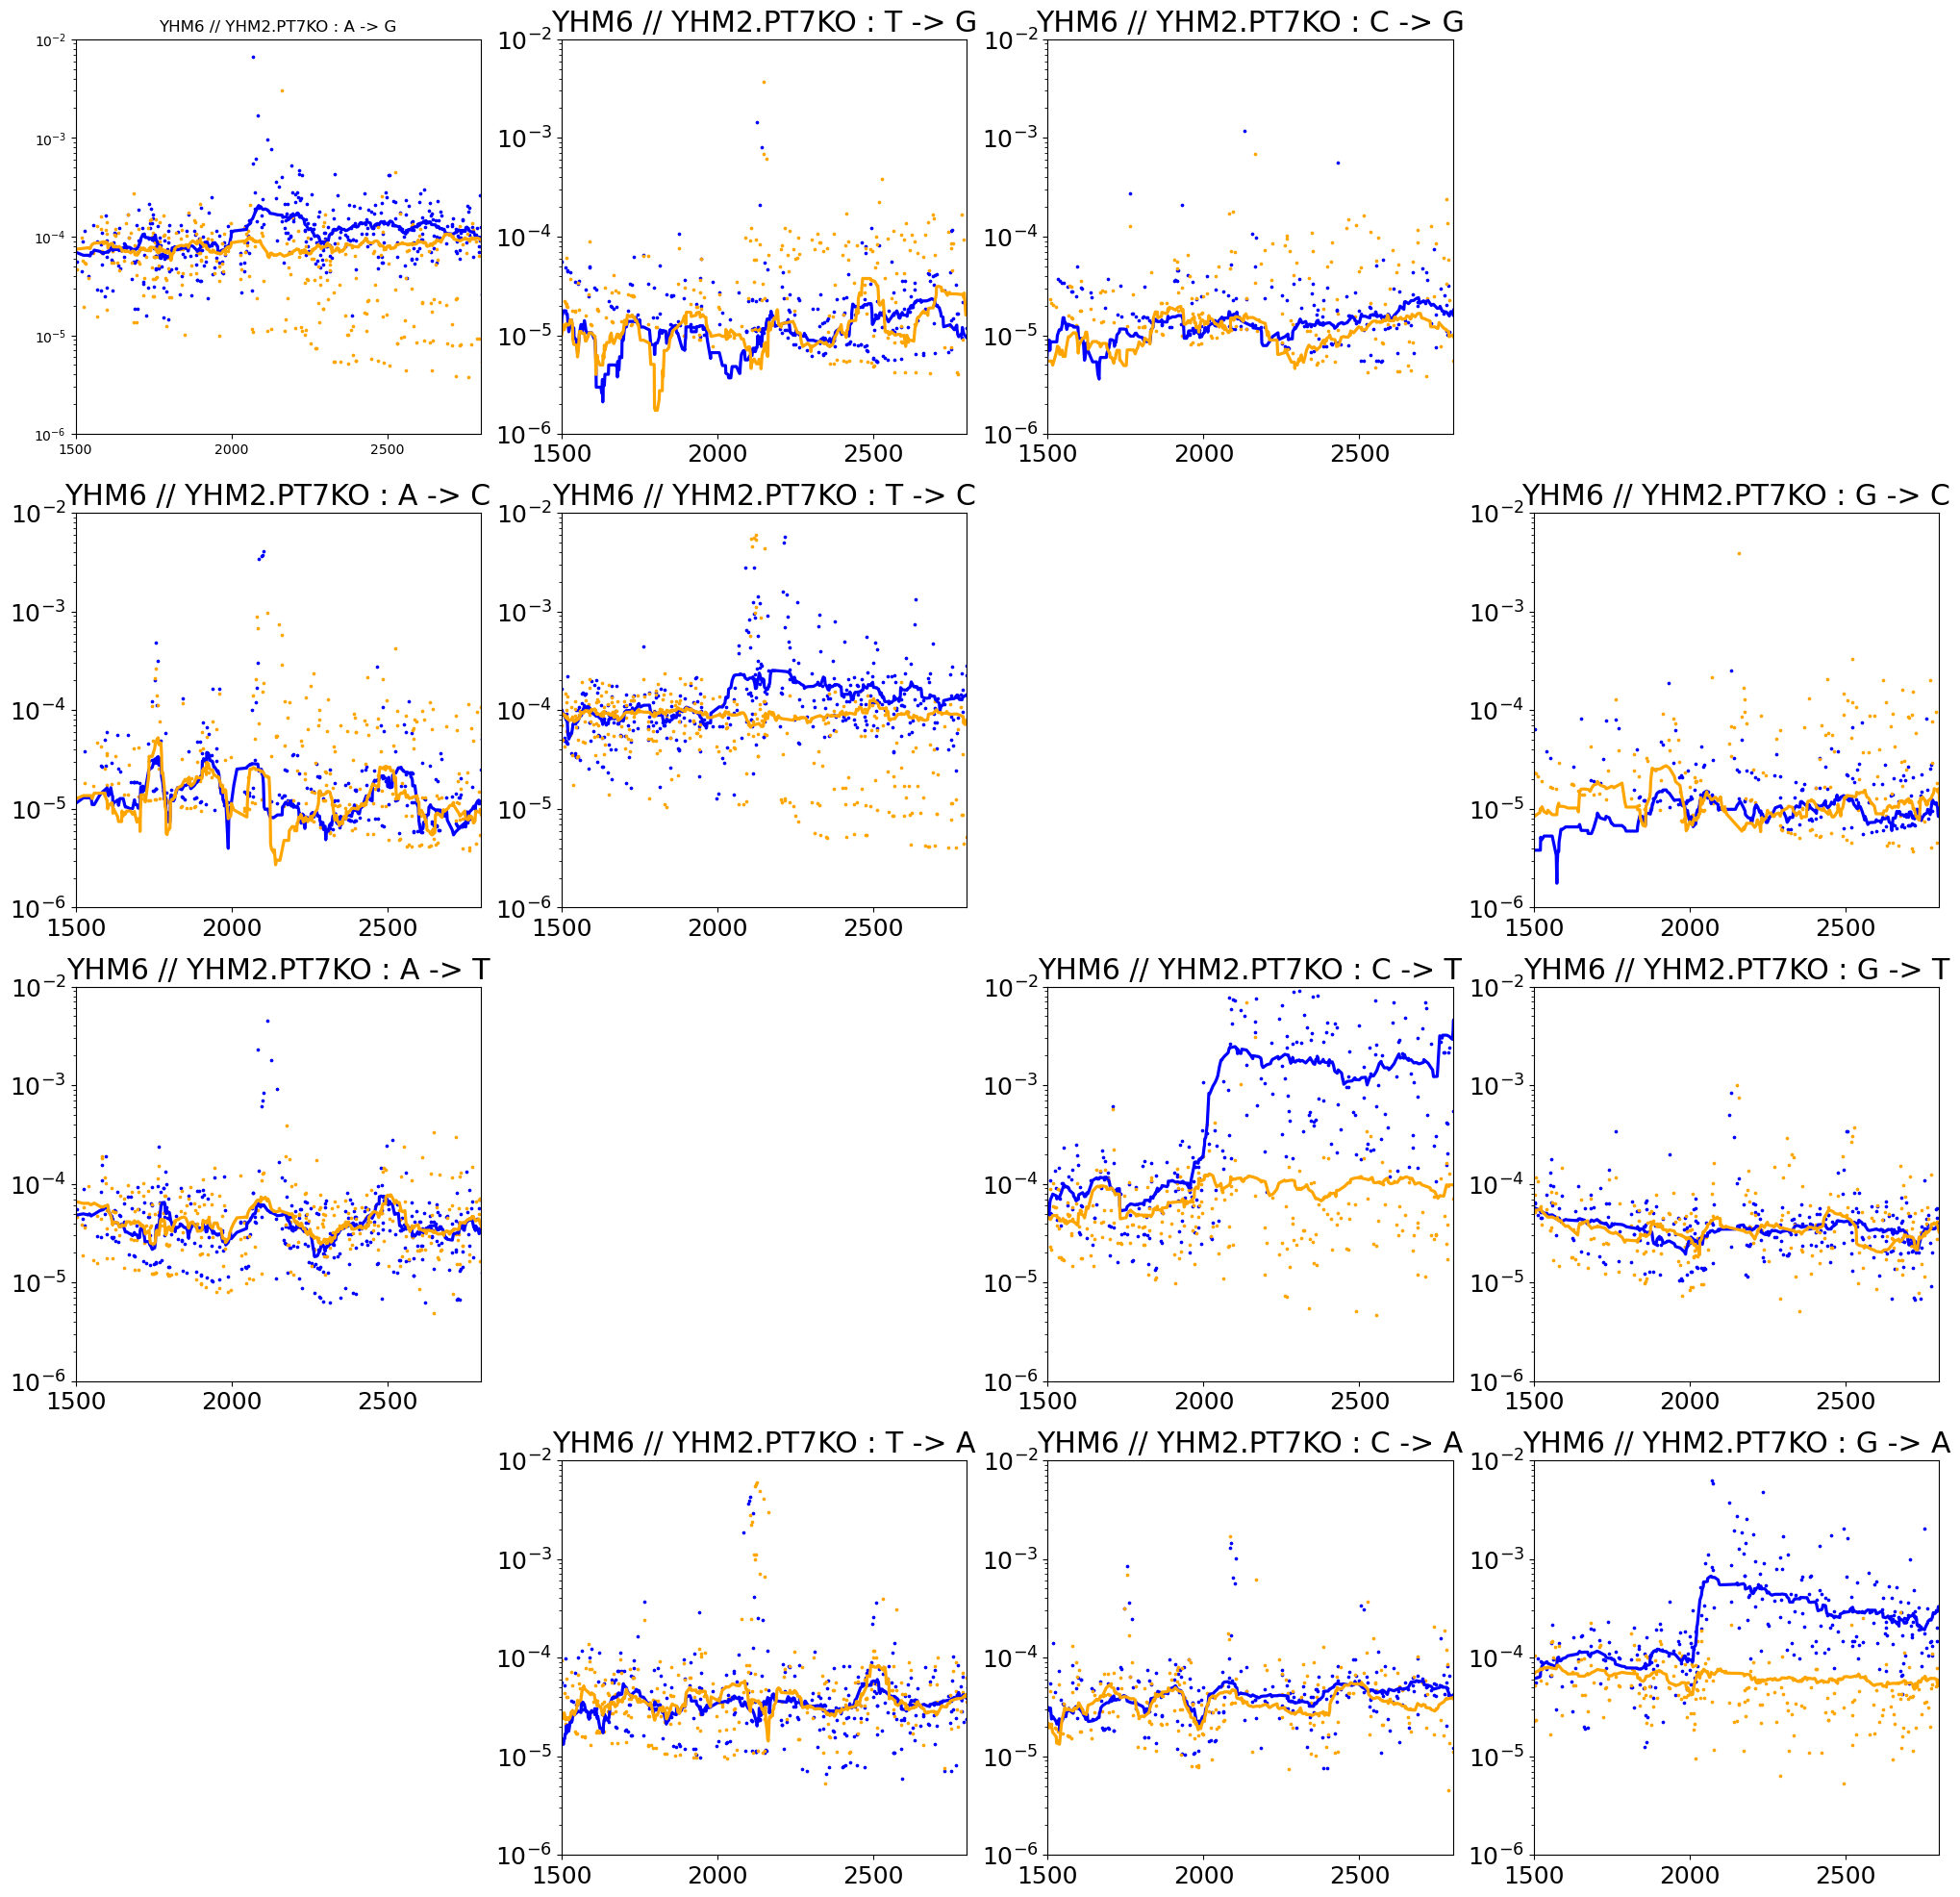

In [5]:
#plot 4x4 mutation plots across the range of target gene
#select which files to play the data from 
play1, play2 = 1,4

#use function to plot averaging curves and dots
#
#    window = is the averaging length to create average curves with
#    Xrange = region of gene to plot data for
#    savefig = can save figure if True
#    machine = can select different machines for rescaling (e.g. miseq, hiseq, nextseq)
#    remove_out = remove outliers from the averaging curve if > 3std dev from the local average

runATCG( Mnormlist[play1], Mnormlist[play2],
        names[play1], names[play2], window=20, Xrange=[1500,2800], savefig=False, machine='miseq', remove_out=True)

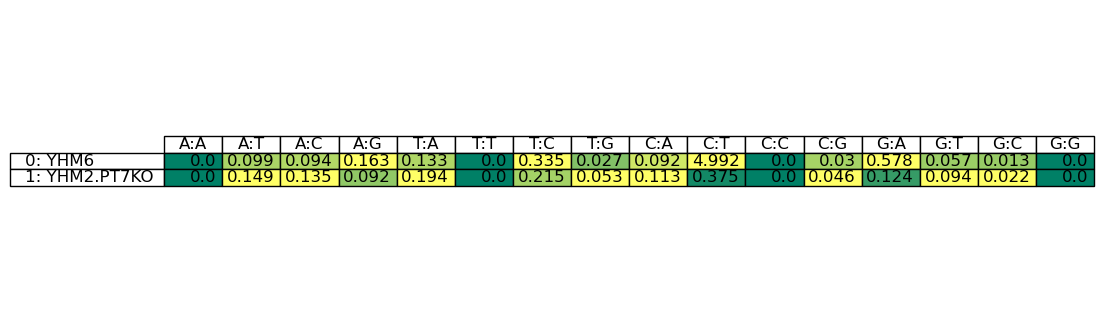

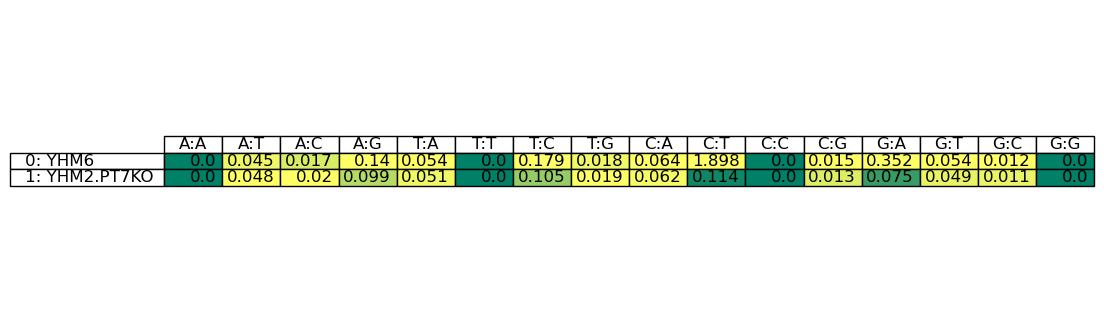

In [6]:
#select files to plot
filt=[1,4]

#pulls rows for naming and analysis
rows = np.array(names)[filt]
Minp = Mnormlist[filt]

#generates mutation rate tables for the selected rows of Mnormlist, with row names as 'rows'
#rates are times 1E-3
table_output(Minp, x1=2100, x2=2700, rows=rows) #full gene length
table_output(Minp, x1=2500, x2=2700, rows=rows) #1000-1200bp



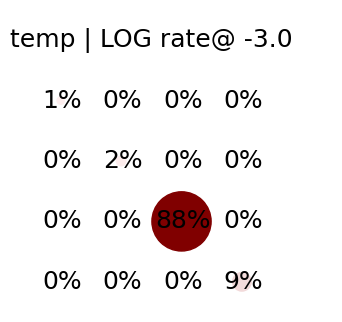

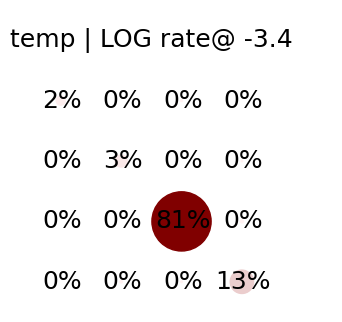

In [7]:
runA_heatmap(Mnormlist[4], Mnormlist[1], sumX1X2=[2100,2700]) #full gene length
runA_heatmap(Mnormlist[4], Mnormlist[1],sumX1X2=[2500,2700]) #1000-1200bp

#horizontal order: ATCG
#vertical order: GCTA